<a href="https://colab.research.google.com/github/MahamShafiq/Qiskit/blob/master/Quantum_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




#**Hybrid quantum-classical Machine Learning with PyTorch and Qiskit**

The point of this exercise was to get you thinking about integrating techniques from ML and quantum computing in order to investigate if there is indeed some element of interest - and thanks to PyTorch and Qiskit, this becomes a little bit easier.

#Install Qiskit

To get started we'll need to install Qiskit. If you have Python >= 3.5 and Jupyter installed you can run this locally. Or alternatively you can run this in Google Colab (if you have a Google account)

In [2]:
!pip install qiskit

     |████████████████████████████████| 2.9MB 5.6MB/s 
     |████████████████████████████████| 23.0MB 31.2MB/s 
     |████████████████████████████████| 143kB 37.4MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 1.8MB 33.7MB/s 
     |████████████████████████████████| 5.6MB 32.4MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 153kB 47.8MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 24.3MB 131kB/s 
     |████████████████████████████████| 573kB 32.6MB/s 
     |████████████████████████████████| 2.3MB 48.3MB/s 
  Created wheel for qiskit: filename=qiskit-0.16.1-cp36-none-any.whl size=2897 sha256=a9cd1aab4e4f6ff8e480a6c6e921b1facfc0d4220ff658866188ecdf4fc48604
  Stored in directory: /root/.cache/pip/wheels/f4/97/50/304a2fdb18113830f


## Importing Necessary Qiskit and Pytorch Packages

In [0]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from matplotlib import pyplot as plt
from time import time
%matplotlib inline


#MNIST Hand Written Digits Classification

##Data Loading and Preprocessing


Extracting ./mnistdata/MNIST/raw/train-images-idx3-ubyte.gz to ./mnistdata/MNIST/raw



Extracting ./mnistdata/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnistdata/MNIST/raw



Extracting ./mnistdata/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnistdata/MNIST/raw



Extracting ./mnistdata/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnistdata/MNIST/raw
Processing...
Done!
torch.Size([1, 1, 28, 28])
torch.Size([1])


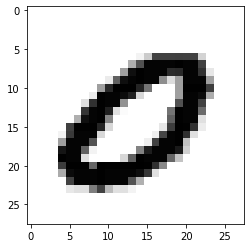

In [4]:
def preprocess(trainset):
    labels = trainset.targets
    labels = labels.numpy()
    index1 = np.where(labels == 0) # filter 3's
    index2 = np.where(labels == 1) # filter on 5's
    n=200 # Number of datapoints per class 
    index = np.concatenate((index1[0][0:n],index2[0][0:n])) 
    trainset.targets = labels[index] 
    trainset.data = trainset.data[index]
    return trainset

#converts the image into tensors
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 
trainset = datasets.MNIST(root='./mnistdata', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(preprocess(trainset), batch_size=1, shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

## - Tensor to List

In [0]:
def to_numbers(tensor_list):
    list = []
    for tensor in tensor_list:
        list += [tensor.item()]
    return list

## **QISKIT CIRCUIT**

In [0]:
class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

# Torch Circuit

In [0]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value]) # store the result as a torch tensor
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        # Obtain paramaters 
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s  # Shift up by s
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s # Shift down by s
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

In [0]:
qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.h1 = nn.Linear(320, 50)
        self.h2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.h1(x))
        x = F.dropout(x, training=self.training)
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  # Normalise the inputs to 1 or 0
        x = torch.cat((x, 1-x), -1)
        return x

In [28]:
network = Net()
print(network)
optimizer = optim.SGD(network.parameters(), lr=0.003, momentum=0.9)
epochs = 30
time0 = time()
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(trainloader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print("Loss = {:.2f} after epoch #{:2d}".format(loss_list[-1],epoch+1))
    #print(loss_list[-1])

# Normalise the loss between 0 and 1
print("Training finished, took {:.2f}s  after epoch #{:2d}".format(time() - time0,epochs))
for i in range(len(loss_list)):
    loss_list[i] += 1

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (h1): Linear(in_features=320, out_features=50, bias=True)
  (h2): Linear(in_features=50, out_features=1, bias=True)
)
Loss = -0.69 after epoch # 1
Loss = -0.77 after epoch # 2
Loss = -0.78 after epoch # 3
Loss = -0.79 after epoch # 4
Loss = -0.80 after epoch # 5
Loss = -0.80 after epoch # 6
Loss = -0.81 after epoch # 7
Loss = -0.82 after epoch # 8
Loss = -0.81 after epoch # 9
Loss = -0.82 after epoch #10
Loss = -0.82 after epoch #11
Loss = -0.82 after epoch #12
Loss = -0.82 after epoch #13
Loss = -0.81 after epoch #14
Loss = -0.81 after epoch #15
Loss = -0.82 after epoch #16
Loss = -0.82 after epoch #17
Loss = -0.82 after epoch #18
Loss = -0.82 after epoch #19
Loss = -0.82 after epoch #20
Loss = -0.82 after epoch #21
Loss = -0.82 after epoch #22
Loss = -0.82 after epoch #23
Loss = -0.83 after epoch #24
Loss = -0.

Text(0, 0.5, 'Loss')

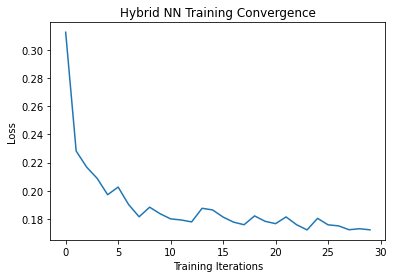

In [32]:
# Plot the loss per epoch
plt.plot(np.arange(epochs),loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel('Training Iterations')
plt.ylabel('Loss')